## Introduction

We will be using the **FinBERT** transformer model to predict sentiment from current financial news headlines.

FinBERT, a specialized BERT model in the financial domain, is a pre-trained learning model of language representation. The model can be used to predict sentiment of a news article or headline which can be useful for understanding market conditions and context.

The Financial PhraseBank used to train this model is credited to the following research article: [Malo, P., Sinha, A., Takala, P., Korhonen, P., & Wallenius, J. (2013, July 23). Good debt or bad debt: Detecting semantic orientations in economic texts. arXiv.org. Retrieved February 28, 2023, from https://arxiv.org/abs/1307.5336](https://arxiv.org/pdf/1307.5336.pdf)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

pd.set_option('display.max_colwidth', None)
%matplotlib inline

## Load Data

In [2]:
import codecs

# Open the input file for reading with the original encoding
with codecs.open('Sentences_AllAgree.txt', 'r', encoding='ISO-8859-1') as f:
    # Read the file content
    file_content = f.read()

# Open the output file for writing with utf-8 encoding
with codecs.open('Sentences_AllAgree_new.txt', 'w', encoding='utf-8') as f:
    # Write the file content with utf-8 encoding
    f.write(file_content)
    
# Load the new UTF-8 encoded file into a Pandas Dataframe
df = pd.read_csv('Sentences_AllAgree_new.txt', delimiter='\t')
display(df.head(5))

,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral"
0,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .@positive"
1,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .@positive"
2,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .@positive
3,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .@positive"
4,"Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn .@positive"


## Clean Data

As seen above, the data needs to be preprocessed before proceeding with analysis. Currently, the first row is placed in the columns section of the dataframe; we will shift this input one cell below with the following manipulation. 

In addition, we will separate each string at the `"@"` character using the .split() method. We can then separate the results into two columns named `news headline` and `sentiment`.

In [3]:
# Set column value to new row
new_row = list(df.columns)

# Insert the new row above the first row
df.loc[-1] = new_row
df.index = df.index + 1
df = df.sort_index()
display(df.head())

,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral"
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral"
1,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .@positive"
2,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .@positive"
3,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .@positive
4,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .@positive"


In [4]:
# Look through each row and split at "@" character
df.columns = ['article']
news_article= []
sentiment = []

for index, row in df.iterrows():
    row = row['article'].split('@')
    news_article.append(row[0])
    sentiment.append(row[1])
    
# Create new dataframe
df = pd.DataFrame({"News Article": news_article, "Sentiment": sentiment})
display(df.head())

,News Article,Sentiment
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",neutral
1,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",positive
2,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .",positive
3,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .,positive
4,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .",positive


## Explore Data

**Distribution of word and character count**

First, we will remove all punctuations in each sentence using a combination of regex and string methods. The word length for each sentence will be appended to a list called `word_count` and the same for each character to `character_count`. 

In [5]:
import re

# Loop through each row and find word/character count
word_count = []
character_count = []

for i in range(len(df['News Article'])):
    # Remove any punctuations
    sentence = re.sub(r'[^\w\s]', '', df['News Article'][i])
    
    # Split sentence into list of words
    words = sentence.split()
    extracted_words = []
    
    # Iterate through each word to see if it is alphabetic
    for word in words:
        if word.isalpha():
            extracted_words.append(word)
    
    # Join list of extracted words together and append character count to list
    extracted_sentence = ' '.join(extracted_words)
    character_count.append(len(extracted_sentence))
    
    # Split extracted sentence into separate words and append word count to list
    split_sentence = extracted_sentence.split()
    word_count.append(len(split_sentence))

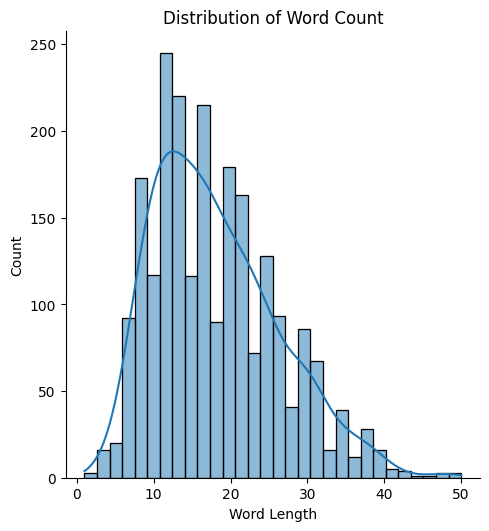

In [6]:
# Plot distribution of word count
sns.displot(word_count, kde=True)
plt.title('Distribution of Word Count')
plt.xlabel('Word Length')
plt.show()

The word count distribution appears to be normally distributed with the highest frequencies around 15-20 words. 

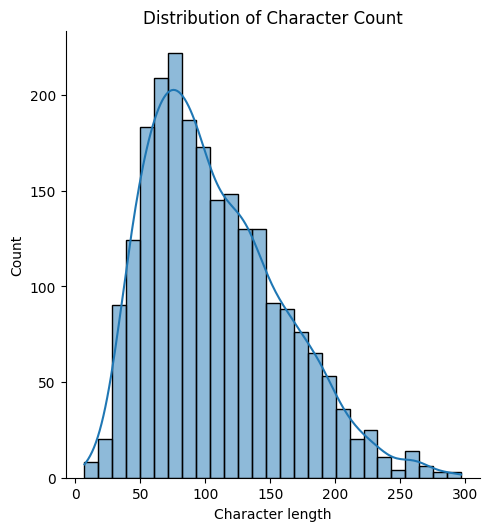

In [7]:
# Plot distribution of character count
sns.displot(character_count, kde=True)
plt.title('Distribution of Character Count')
plt.xlabel('Character length')
plt.show()

Similarly, the distribution of character length appears to be normally distributed with the highest frequencies around 60-100 characters. 

**Distribution of sentiment**

[]

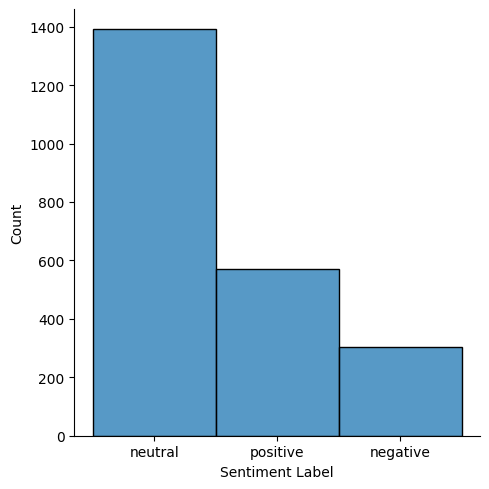

In [8]:
# Plot distribution of sentiment labels
sns.displot(df['Sentiment'], kind='hist')
plt.xlabel('Sentiment Label')
plt.plot()

Most of news articles provided in the dataset were `neutral` labels. From first glance, the data is considered imbalance so we may need to assign weights accordingly prior to modeling. This statistical adjustment will help improve the accuracy of the classification model and will attempt to alleviate overfitting.

## Implementation of FINBERT

In [9]:
# Test data
articles_array = np.array(df['News Article'])
np.random.shuffle(articles_array)
test = (articles_array[:30]).tolist()
print(test)

['Sales in Finland decreased by 2.0 % , and international sales decreased by 9.3 % in terms of euros , and by 15.1 % in terms of local currencies .', 'The transaction is expected to be finalized by Dec 2009 .', 'Market share decreased on the route between Helsinki in Finland and Tallinn in Estonia by 0.1 percentage points to 24.8 % .', 'Registration is required .', 'The share subscription period for stock options 2007A is between 1 April 2010 and 31 March 2012 .', 'Net profit in the three months through March 31 fell to (  x20ac ) 103 million ( US$ 165 million ) from (  x20ac ) 131 million a year earlier , the Finnish company said .', "Following the demerger , the vice president of the group 's pharmaceutical trade in Finland , Jukka Niemi , will be appointed managing director of Oriola in addition to his current responsibilities .", 'Increase in the number of shares is based on the option rights which were granted to the management of the company under the stock option plan 2006 .', '

In [10]:
# Pretrain model with FinBert
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [11]:
# Create inputs 
inputs = tokenizer(test, padding = True, truncation = True, return_tensors = 'pt')
print(inputs)

{'input_ids': tensor([[  101,  4341,  1999,  ...,     0,     0,     0],
        [  101,  1996, 12598,  ...,     0,     0,     0],
        [  101,  3006,  3745,  ...,     0,     0,     0],
        ...,
        [  101,  4082,  5618,  ...,     0,     0,     0],
        [  101,  5796,  2474,  ...,     0,     0,     0],
        [  101, 15253,  2080,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [12]:
# Inference
outputs = model(**inputs)
print(outputs.logits.shape)

torch.Size([30, 3])


In [13]:
# Postprocessing with softmax
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)
print(len(predictions))

tensor([[0.0085, 0.9731, 0.0184],
        [0.0601, 0.0116, 0.9283],
        [0.0079, 0.9744, 0.0177],
        [0.0200, 0.0395, 0.9405],
        [0.0164, 0.0380, 0.9456],
        [0.0067, 0.9761, 0.0171],
        [0.0269, 0.0238, 0.9494],
        [0.0813, 0.0090, 0.9097],
        [0.9324, 0.0101, 0.0575],
        [0.0425, 0.0129, 0.9447],
        [0.0219, 0.0353, 0.9428],
        [0.9479, 0.0310, 0.0211],
        [0.0286, 0.0242, 0.9472],
        [0.0628, 0.0150, 0.9223],
        [0.1623, 0.0080, 0.8297],
        [0.0205, 0.0354, 0.9441],
        [0.1318, 0.0101, 0.8582],
        [0.2231, 0.0286, 0.7484],
        [0.0086, 0.9767, 0.0147],
        [0.2544, 0.4774, 0.2682],
        [0.0717, 0.0126, 0.9157],
        [0.9557, 0.0239, 0.0204],
        [0.8114, 0.0170, 0.1717],
        [0.0585, 0.0118, 0.9296],
        [0.0787, 0.0102, 0.9111],
        [0.0257, 0.0327, 0.9415],
        [0.9465, 0.0169, 0.0366],
        [0.9506, 0.0279, 0.0215],
        [0.0979, 0.0083, 0.8938],
        [0.951

In [14]:
# Model classes
model.config.id2label

{0: 'positive', 1: 'negative', 2: 'neutral'}

## Final Predictions

In [16]:
# Formatting results as pandas dataframe

# Headline sentiment
positive = predictions[:, 0].tolist()
negative = predictions[:, 1].tolist()
neutral = predictions[:, 2].tolist()

table = {'Article':test,
        'Positive':positive,
        'Negative':negative,
        'Neutral':neutral}

df = pd.DataFrame(table, columns=['Article', 'Positive', 'Negative', 'Neutral'])

display(df)

,Article,Positive,Negative,Neutral
0,"Sales in Finland decreased by 2.0 % , and international sales decreased by 9.3 % in terms of euros , and by 15.1 % in terms of local currencies .",0.008455,0.973128,0.018417
1,The transaction is expected to be finalized by Dec 2009 .,0.060103,0.011628,0.928269
2,Market share decreased on the route between Helsinki in Finland and Tallinn in Estonia by 0.1 percentage points to 24.8 % .,0.007879,0.974372,0.017749
3,Registration is required .,0.020011,0.039514,0.940474
4,The share subscription period for stock options 2007A is between 1 April 2010 and 31 March 2012 .,0.016447,0.037957,0.945596
5,"Net profit in the three months through March 31 fell to ( x20ac ) 103 million ( US$ 165 million ) from ( x20ac ) 131 million a year earlier , the Finnish company said .",0.006742,0.976132,0.017126
6,"Following the demerger , the vice president of the group 's pharmaceutical trade in Finland , Jukka Niemi , will be appointed managing director of Oriola in addition to his current responsibilities .",0.026874,0.023767,0.949360
7,Increase in the number of shares is based on the option rights which were granted to the management of the company under the stock option plan 2006 .,0.081323,0.008957,0.909720
8,Biohit already services many current Genesis customers and the customer base is expected to expand as a result of this agreement .,0.932396,0.010092,0.057512
9,The estimated value of the deal is USD 9.2 million .,0.042460,0.012872,0.944668
